In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import tf_utils
import time

In [2]:
def test():
    y_hat=tf.constant(36,name="y_hat")
    y=tf.constant(39,name="y")
    loss=tf.Variable((y-y_hat)**2,name="loss")
    init=tf.global_variables_initializer()
    with tf.Session()as session:
        session.run(init)
        print(session.run(loss))
    session.close()

In [3]:
def linear_function():
    np.random.seed(1)
    W=np.random.randn(4,3)
    X=np.random.randn(3,1)
    b=np.random.randn(4,1)
    c=tf.add(tf.matmul(W,X),b)
    session=tf.Session()
    print(session.run(c))
    session.close()

In [4]:
def one_hot_matrix(lables,C):
    C=tf.constant(C,name="C")
    one_hot_matrix=tf.one_hot(indices=lables,depth=C,axis=0)
    session=tf.Session()
    one_hot=session.run(one_hot_matrix)
    session.close()
    return one_hot

In [5]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X,Y

In [6]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed)
    m=X.shape[1]
    batches_complete_size=math.floor(m/mini_batch_size)
    permutation=list(np.random.permutation(m))
    mini_batchs=[]
    batch_X=X[:,permutation]
    batch_Y=Y[:,permutation].reshape[1,m]
    for k in range(batches_complete_size):
        mini_batch_X=batch_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y=batch_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batchs.append(mini_batch)
    if m%mini_batch_size!=0:
        mini_batch_X=batch_X[:,batches_complete_size*mini_batch_size:m]
        mini_batch_Y=batch_Y[:,batches_complete_size*mini_batch_size:m]
        mini_batch=(mini_batch_X,mini_batch_Y)
        mini_batchs.append(mini_batch)
    return mini_batchs

In [7]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters

In [8]:
def forward_propagation(X,parameters):
    W1=parameters["W1"]
    W2=parameters["W2"]
    W3=parameters["W3"]
    b1=parameters["b1"]
    b2=parameters["b2"]
    b3=parameters["b3"]
    Z1=tf.add(tf.matmul(W1,X),b1)
    A1=tf.nn.relu(Z1)
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.nn.relu(Z2)
    Z3=tf.add(tf.matmul(W3,A2),b3)
    return Z3

In [9]:
def compute_cost(Z3,Y):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [10]:
def model(X_train,Y_train,X_test,Y_test,
        learning_rate=0.0001,num_epochs=1500,minibatch_size=32,
        print_cost=True,is_plot=True):
    ops.reset_default_graph() 
    costs=[]
    seed=1
    (n_x,m)=X_train.shape
    n_y=Y_train.shape[0]
    X,Y=create_placeholders(n_x,n_y)
    parameter=initialize_parameters()
    Z3=forward_propagation(X,parameter)
    cost=compute_cost(Z3,Y)
    optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as session:
        session.run(init)
        for epoch in range(num_epochs):
            num_batches=int(m/minibatch_size)
            epoch_cost=0
            seed=seed+1
            mini_batches=tf_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed)
            for batch in mini_batches:
                (mini_batch_X,mini_batch_Y)=batch
                _,minibatch_cost=session.run([optimizer,cost],feed_dict={X:mini_batch_X,Y:mini_batch_Y})
                epoch_cost = epoch_cost + minibatch_cost / num_batches
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                #是否打印：
                if print_cost and epoch % 100 == 0:
                        print("epoch = " + str(epoch) + "    epoch_cost = " + str(epoch_cost))
        #是否绘制图谱
        if is_plot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
         #保存学习后的参数
        parameters = session.run(parameter)
        print("参数已经保存到session。")

        #计算当前的预测结果
        correct_prediction = tf.equal(tf.argmax(Z3),tf.argmax(Y))
        print(correct_prediction)
        #计算准确率
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        
        print("训练集的准确率：", accuracy.eval({X: X_train, Y: Y_train}))
        print("测试集的准确率:", accuracy.eval({X: X_test, Y: Y_test}))
        print(correct_prediction)
    return parameters

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]]

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

epoch = 0    epoch_cost = 1.8484228090806443
epoch = 100    epoch_cost = 1.1012501770799812
epoch = 200    epoch_cost = 0.7488055265311041
epoch = 300    epoch_cost = 0.546511134414962
epoch = 400    epoch_cost = 0.38066243809280964
epoch = 500    epoch_cost = 0.2561427580587791
epoch = 600    epoch_cost = 0.1949320880301071
epoch = 700    epoch_co

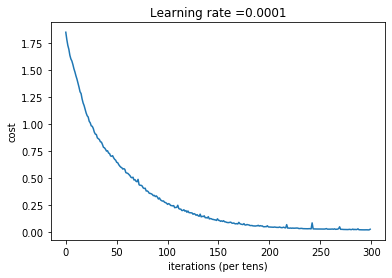

UnboundLocalError: local variable 'parameters' referenced before assignment

In [11]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()

X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T #每一列就是一个样本
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T

#归一化数据
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255

#转换为独热矩阵
Y_train = tf_utils.convert_to_one_hot(Y_train_orig,6)
Y_test = tf_utils.convert_to_one_hot(Y_test_orig,6)
print(Y_train)
#开始时间
start_time = time.clock()
#开始训练
parameters = model(X_train, Y_train, X_test, Y_test)
#结束时间
end_time = time.clock()
#计算时差
print("CPU的执行时间 = " + str(end_time - start_time) + " 秒" )